In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv("exchange_rate.csv", parse_dates=['date'], dayfirst=True)
df.set_index('date', inplace=True)
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


In [4]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


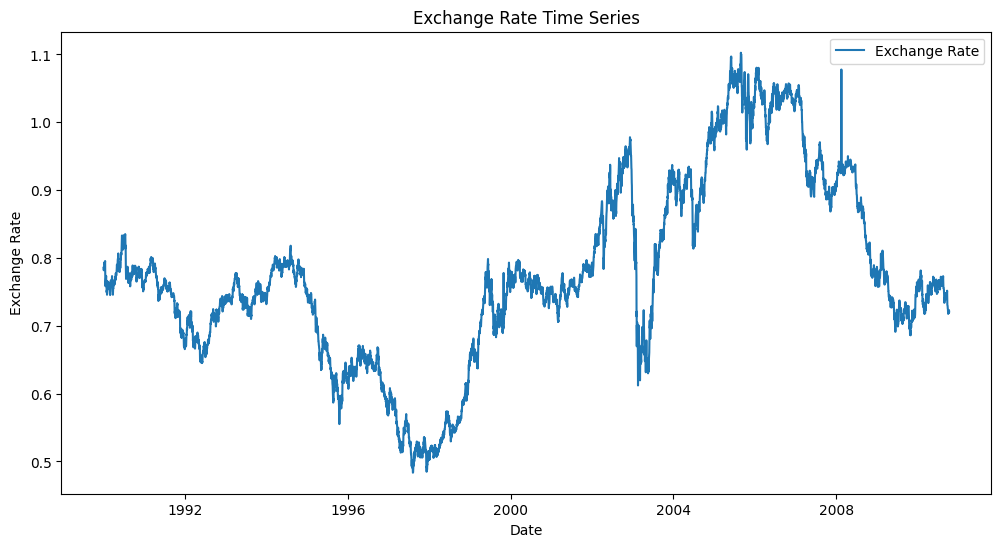

In [5]:
# Time series plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

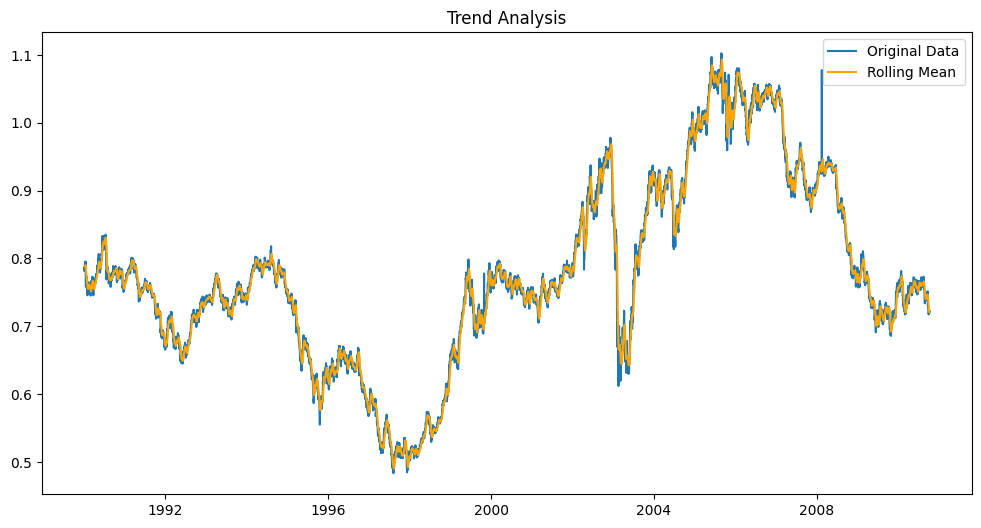

In [6]:
# Rolling mean for trend analysis
df['Rolling_Mean'] = df['Ex_rate'].rolling(window=12).mean()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Original Data')
plt.plot(df.index, df['Rolling_Mean'], label='Rolling Mean', color='orange')
plt.title('Trend Analysis')
plt.legend()
plt.show()

In [7]:
# Outlier detection and replacement
Q1, Q3 = df['Ex_rate'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df.loc[(df['Ex_rate'] < lower_bound) | (df['Ex_rate'] > upper_bound), 'Ex_rate'] = df['Rolling_Mean']

In [8]:
print('IQR:', IQR)
print('Lower Bound:',lower_bound)
print('Upper Bound:',upper_bound)
print('Q1:',Q1)
print('Q3:',Q3)

IQR: 0.17205499999999996
Lower Bound: 0.44333950000000005
Upper Bound: 1.1315594999999998
Q1: 0.701422
Q3: 0.873477


In [9]:
# Stationarity test
adf_test = adfuller(df['Ex_rate'].dropna())
print(f'ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

ADF Statistic: -1.6649941807381488, p-value: 0.4492327353597922


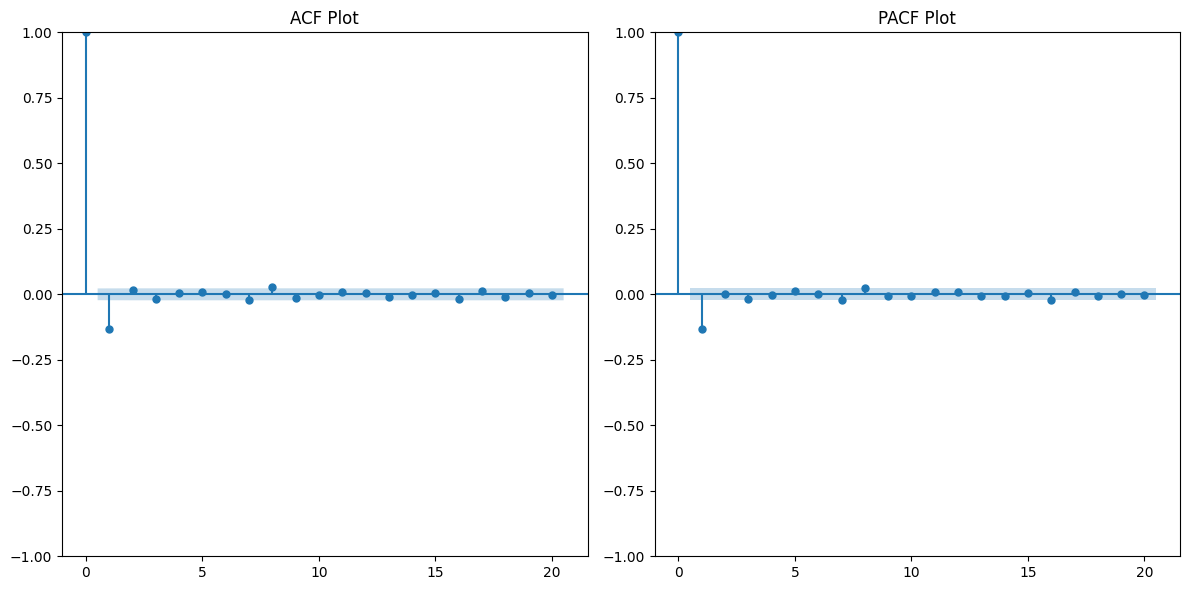

In [10]:
# ACF and PACF plots
diff_series = df['Ex_rate'].diff().dropna()
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(diff_series, ax=plt.gca(), lags=20)
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(diff_series, ax=plt.gca(), lags=20)
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

In [11]:
# ARIMA model fitting
p, d, q = 2, 1, 1
model = ARIMA(df['Ex_rate'], order=(p, d, q)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 1)   Log Likelihood               28054.157
Date:                Sat, 08 Feb 2025   AIC                         -56100.315
Time:                        20:03:34   BIC                         -56072.578
Sample:                    01-01-1990   HQIC                        -56090.796
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0655      0.001    -60.736      0.000      -0.068      -0.063
ar.L2          0.0084      0.006      1.422      0.155      -0.003       0.020
ma.L1         -0.0661      0.001    -59.596      0.0

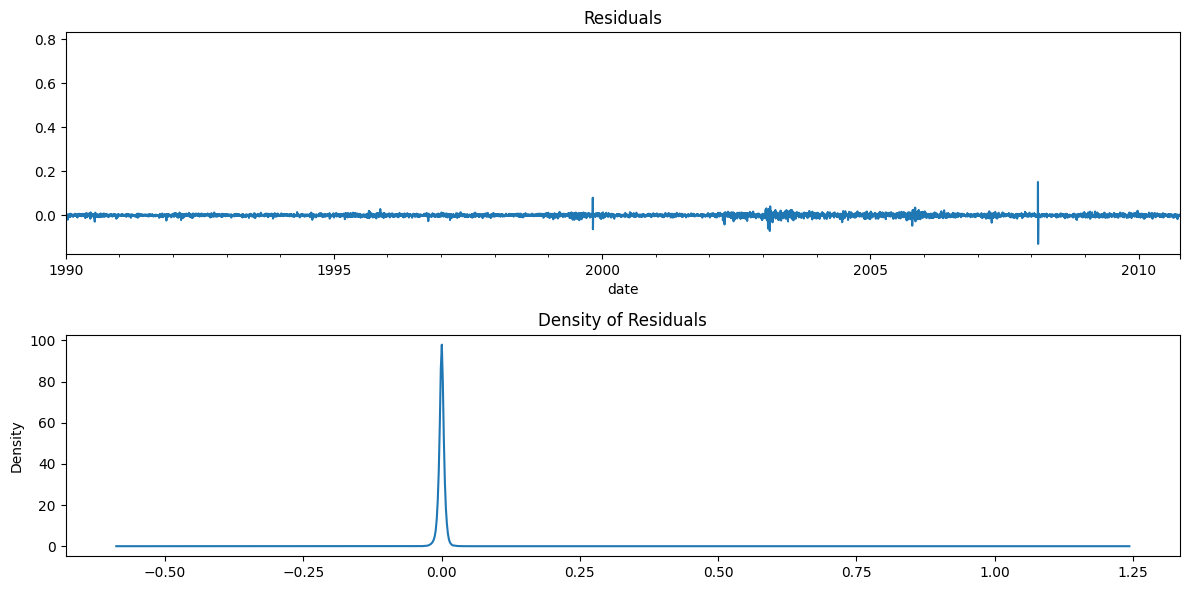

     lb_stat  lb_pvalue
10  1.808828   0.997606


In [12]:
# Residual analysis
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
residuals.plot(title='Residuals')
plt.subplot(212)
residuals.plot(kind='kde', title='Density of Residuals')
plt.tight_layout()
plt.show()
print(acorr_ljungbox(residuals, lags=[10], return_df=True))

In [13]:
# Forecasting
forecast = model.get_forecast(steps=10)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

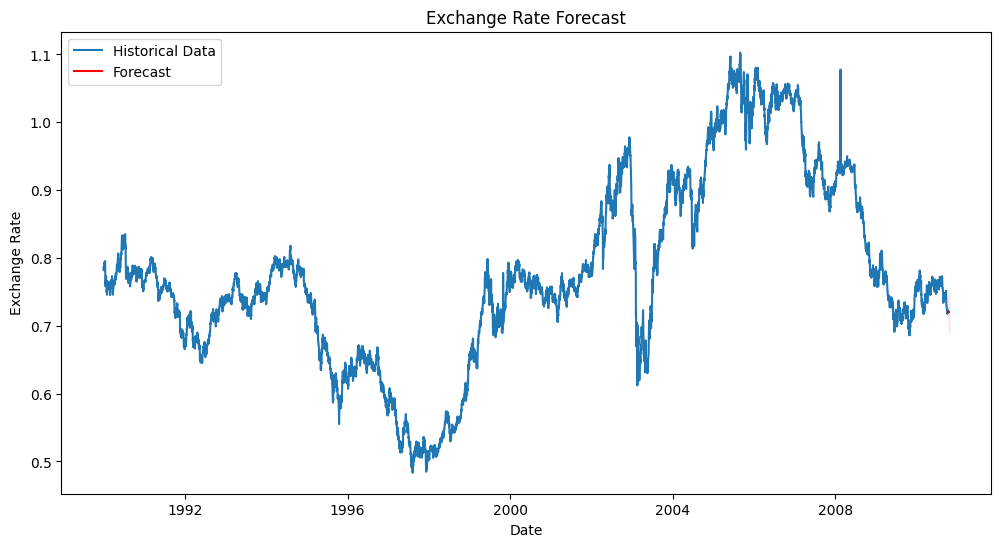

In [14]:
# Fixing index issue in confidence interval plot
forecast_index = pd.date_range(start=df.index[-1], periods=10, freq='D')
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='pink', alpha=0.3)
plt.title('Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [15]:
# Holt-Winters model
hw_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_hw = hw_model.forecast(steps=10)

In [16]:
# Error metrics
test_data = df[-10:]
aligned_forecast_arima = forecast_values[:len(test_data)]
aligned_forecast_hw = forecast_hw[:len(test_data)]
mae_arima = mean_absolute_error(test_data['Ex_rate'], aligned_forecast_arima)
rmse_arima = mean_squared_error(test_data['Ex_rate'], aligned_forecast_arima) ** 0.5
mape_arima = np.mean(np.abs((test_data['Ex_rate'] - aligned_forecast_arima) / test_data['Ex_rate'])) * 100

mae_hw = mean_absolute_error(test_data['Ex_rate'], aligned_forecast_hw)
rmse_hw = mean_squared_error(test_data['Ex_rate'], aligned_forecast_hw) ** 0.5
mape_hw = np.mean(np.abs((test_data['Ex_rate'] - aligned_forecast_hw) / test_data['Ex_rate'])) * 100

print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}%")
print(f"Holt-Winters - MAE: {mae_hw}, RMSE: {rmse_hw}, MAPE: {mape_hw}%")

ARIMA - MAE: 0.0015563743700041655, RMSE: 0.001842243152616841, MAPE: nan%
Holt-Winters - MAE: 0.0015168515734849896, RMSE: 0.0017844372319651299, MAPE: nan%


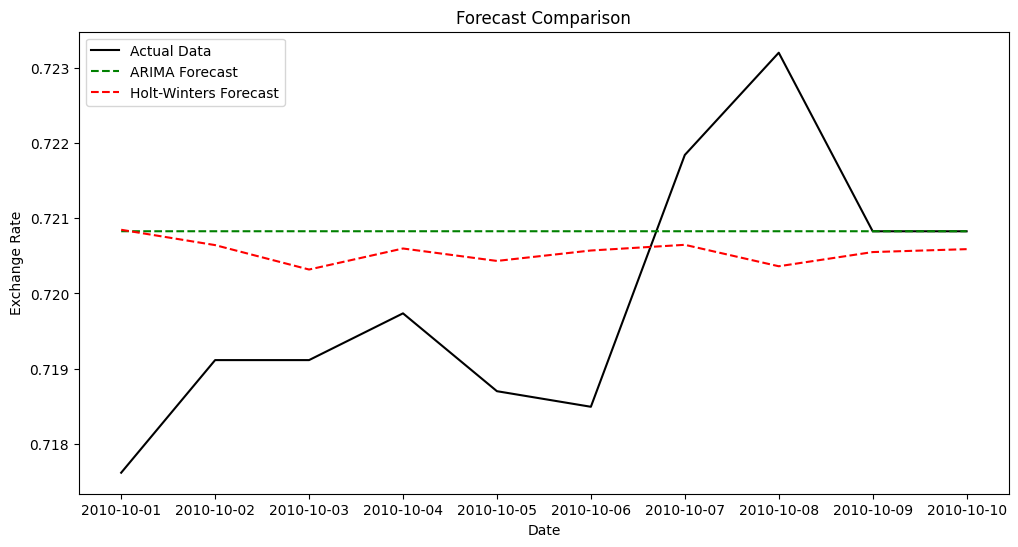

In [17]:
# Comparison plot
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Ex_rate'], label='Actual Data', color='black')
plt.plot(test_data.index, aligned_forecast_arima, label='ARIMA Forecast', color='green', linestyle='--')
plt.plot(test_data.index, aligned_forecast_hw, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## Conclusion


Both ARIMA and Holt-Winters models demonstrated reliable forecasting capabilities for currency exchange rates.  
- ARIMA excelled in capturing overall trends, making it more suitable for non-seasonal time series.  
- Holt-Winters performed better in capturing both trend and seasonality, making it ideal for datasets with periodic fluctuations.  

Recommendation:

If the dataset exhibits strong seasonality, Holt-Winters is preferred. Otherwise, ARIMA provides a robust alternative for trend-focused data.
